# Imports

In [1]:
# Links:
# https://www.askpython.com/python/examples/stock-price-prediction-python
# https://www.codespeedy.com/predicting-stock-price-using-lstm-python-ml/

In [2]:
%%capture
# %%capture: Show now output for this cell
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import math
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
import tensorflow as tf
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
# https://pydata.github.io/pandas-datareader/
import pandas_datareader as pdr
# pickle
import pickle

2021-10-16 12:46:54.014331: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-16 12:46:54.014376: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Data importing and visualization

In [3]:
def get_stock_data(ticker_symbols, start_date, end_date = datetime.today(), date_index = True, columns="all"):
    '''
    Returns stock data from yahoo for the specified ticker symbols, start and end dates.
    
    PARAMETERS:
    
    - ticker_symbols (list<string>): a list of standard ticker symbols which should be queried. Duplicate values will be ignored. If a ticker symbol could not be found, it is also going to be ignored and a error is printed.
    
    - start_date (datetime.datetime): the first date to fetch data for
    
    - end_date (datetime.datetime): the last date to fetch data for (default is the current date)
    
    - date_index (boolean): if true, the date-column will be used as the index for the dataframes (default). Otherwise, a numerical index is used and the date-date will be stored in a seperate column.
    
    - columns (list<string>): Determines which columns should be returned for each ticker (default = "all"). Options are "High", "Low", "Open", "Close" and "Volume"
    
    RETURNS:
    
    - data (dict<pandas.DataFrame>): A dictionary is returned and the data for each stock can be accessed by data["ticker_symbol"]
    '''
    ticker_symbols = set(ticker_symbols)
    data = {}
    for ticker in ticker_symbols:
        try:
            df = pdr.data.DataReader(ticker, 'yahoo', start = start_date, end = end_date)
            if date_index:
                if "Date" in df.columns:
                    df.set_index = df["Date"]
            else:
                df["Date"] = df.index
                df.index =  range(1, df.shape[0] + 1)
            if columns != "all":
                if len(columns) > 0:
                    for column in df.columns:
                        if column not in columns:
                            df = df.drop([column], axis = 1)
            if df.isnull().sum().sum() != 0:
                print(f"WARN: {df.isnull().sum().sum() } data points are missing for ticker symbol {ticker}")
            data[ticker] = df
        except:
            print(f"Data could not be fetched for ticker {ticker}")
    return data

In [4]:
def plot_data(title, df):
    '''
    Plots the data from a dataframe
    '''
    ax = df.plot(title = title, fontsize = 12)
    ax.set_xlabel("Date")
    ax.set_ylabel("Price in $")
    plt.show()

In [5]:
def tickers_as_columns(data_dict, column="Adj Close"):
    '''
    This method reformats a dictionary generated by the "get_stock_data"-method.
    The structure before is the following
    dict{
            stock1: [[High], [Low], [Close] ...],
            stock2: [[High], [Low], [Close] ...],
            ...
    }
    
    The method creates a dataframe which keeps the dates as the index, but adds a column for each stock based on a chosen value. The default value is "Adj Close".
    '''
    columns = []
    column_names = []
    for key in data_dict:
        column_names.append(key)
        columns.append(data_dict[key][column])
    df = pd.DataFrame(columns, index = column_names)
    return df.T

In [6]:
def get_adj_close_df(ticker_symbols, start_date, end_date = datetime.today()):
    ticker_symbols = set(ticker_symbols)
    df = pd.DataFrame()
    for ticker in ticker_symbols:
        column = pdr.data.DataReader(ticker, 'yahoo', start = start_date, end = end_date)["Adj Close"]
        column.name = ticker
        df = pd.concat([df, column], axis = 1)
   # df = pd.DataFrame(data = columns) #, columns=ticker_symbols, index = range(1, len(columns[1])))
    return df

# Functions for model training

In [7]:
def get_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True,input_shape=(input_shape,1)))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dense(units=25))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [8]:
def train_test_split(dataset, days = 60, train_fraction = 0.7):
    # Get the lenght of 70% of thedata
    training_data_len = math.ceil(len(dataset) * train_fraction)
    # Get the training data
    train_data = dataset[0:training_data_len  , : ]

    # Separate the data into x and y data
    x_train = []
    y_train = []
    # Iterate from day 60 to the last day of the training data
    le = len(train_data)
    for i in range(days,len(train_data)):
        # I think these commands are useless
        # x_train=list(x_train)
        # y_train=list(y_train)
        x_train.append(train_data[i-days:i,0])
        y_train.append(train_data[i,0])

    # Converting the training x and y values to numpy arrays
    x_train, y_train = np.array(x_train), np.array(y_train)

    # Reshaping training s and y data to make the calculations easier
    x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
 
    # Creating a dataset for testing
    test_data = dataset[training_data_len - days: , : ]
    x_test = []
    y_test =  dataset[training_data_len : , : ]
    for i in range(days,len(test_data)):
        x_test.append(test_data[i-days:i,0])

    # 2.  Convert the values into arrays for easier computation
    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
    
    return x_train, y_train, x_test, y_test, training_data_len

In [9]:
def print_rmse(predictions, y_test): 
    rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
    print(rmse)
    return rmse

In [10]:
def scale_data(data):
    scaler = MinMaxScaler(feature_range=(0, 1))
    # Scale/Normalize the data to make all values between 0 and 1
    dataset = scaler.fit_transform(data)
    return scaler, dataset

In [11]:
def rescale_data(data, scaler):
    return scaler.inverse_transform(data)

In [12]:
def make_predictions(model, data):
    predictions =  model.predict(data).reshape(-1, 1)
    return predictions

In [13]:
def plot_approximation(filtered_data, training_data_len, predictions):
    train = filtered_data[:training_data_len]
    valid = filtered_data[training_data_len:].copy()
    valid.loc[:,'Predictions'] = predictions

    plt.title('Model')
    plt.xlabel('Date')
    plt.ylabel('Close')

    plt.plot(train['GOOG'])
    plt.plot(valid[['GOOG', 'Predictions']])

    plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')

    plt.show()

In [14]:
def predict_future(dataset, model, model_dict = True, n_days = 5, days_back = 60):
    # Take the last n days from the dataset. This is the whole data needed for our prediction
    last_n_days = dataset[-days_back:]
    # Rescale that data
    scaler, scaled_data = scale_data(last_n_days)
    # Reshape so that the data can be used with our model
    scaled_data = scaled_data.reshape(1, 60, 1)
    # create new array which can hold the last 60 days and also the data to be predicted
    scaled_data_array = np.zeros((1, days_back + n_days, 1))
    # Copy the data to that new array
    for i in range(scaled_data.shape[1]):
        scaled_data_array[0][i][0] = scaled_data[0][i][0]
    # Iterate through the new days which should be predicted and predict them based on the existing data and the previous predictions
    for i in range(n_days):
        # from 60 + 0 to 60 + 4:
        last_60_temp = scaled_data_array[0, i : i  + days_back:, 0].reshape(1, 60 , 1)
        # print(f"Last 60_temp: {last_60_temp}")
        pred = None
        if model_dict:
            pred = make_predictions(model["model"], last_60_temp)
        else:
            pred = make_predictions(model, last_60_temp)
        #  print(f"Pred.shape: {pred.shape}")
        #  print(f"Pred: {pred}")
        scaled_data_array[0, days_back + i, 0]  = pred
    
    rescaled_prediction = rescale_data(scaled_data_array.reshape(-1, 1), scaler)
    
    return rescaled_prediction[ - n_days: ,0]

In [15]:
def create_model(ticker, name, start_date, end_date = datetime.today(), pred_base_range = 60):
    # Create dictionary to store the model and its metadata
    model_dict = {}
    model_dict["name"] = name
    model_dict["ticker"] = ticker
    model_dict["start_date"] = start_date
    model_dict["end_date"] = end_date
    model_dict["pred_base_range"] = pred_base_range
    
    # Get the data, rescale it and divide it into training and test set
    df = get_adj_close_df([ticker], start_date, end_date = datetime.today())
    df_values = df.values
    scaler, scaled_dataset = scale_data(df_values)
    x_train, y_train, x_test, y_test, training_data_len = train_test_split(scaled_dataset, days = pred_base_range)
    
    # Train a model with the data
    model = get_model(input_shape = x_train.shape[1])
    model.fit(x_train, y_train, batch_size=1, epochs=1)
    model_dict["model"] = model
    
    return model_dict
    #store_model_keras("first_lstm", first_lstm)

In [16]:
def save_model_dict(model_dict, model_dir = "./models/"):
    model = model_dict["model"]
    # First store the model using the Keras function because the model cannot be stored with pickle (weakref-error)
    store_model_keras(model_dict["name"] + "_model", model)
    model_dict["model"] = None
    fileObj = open(model_dir + model_dict["name"] + "_metadata.obj", 'wb')
    pickle.dump(model_dict,fileObj)
    model_dict["model"] = model
    
    fileObj.close()
    
def load_model_dict(model_name, model_dir = "./models/"):
    with open(model_dir + model_name + "_metadata.obj", 'rb') as file:
        # Call load method to deserialze
        model_dict = pickle.load(file)

    model_dict["model"] = load_model(model_name, model_dir)
    return model_dict

def load_model(model_name, model_dir = "./models/"):
    model = tf.keras.models.load_model(model_dir + model_name + "_model")
    return model

def store_model_pickle(name, model, model_dir = "./models/"):
    try:
        model_params = model.get_params()
        fileObj = open(f'{model_dir}{name}_params.obj', 'wb')
        pickle.dump(model_params,fileObj)
        fileObj.close()
    except:
        pass
    fileObj = open(f'{name}.obj', 'wb')
    pickle.dump(model,fileObj)
    fileObj.close()
    
def store_model_keras(name, model, model_dir = "./models/"):
    model.save(f'{model_dir}{name}', save_format="h5" )  # creates a HDF5 file 'my_model.h5'

# Date processing methods

In [97]:
def create_timerange_from_now(include_today = True, n_days = 5, weekends = False):
    '''
    Returns a list of all future dates from now
    '''
    day_list = list()
    if include_today:
        i = 0
    else:
        i = 1
    while len(day_list) < n_days:
        next_day = datetime.now() + timedelta(days=i)
        i = i + 1
        # Consider if the day is on the weekend
        if not weekends:
            if next_day.weekday() < 5:
                day_list.append(next_day)
        else:
            day_list.append(next_day)
    return day_list

def extend_df(df, predictions, new_timerange = None):
    '''
    This methods takes a df of values and appends the predicted values to the dataframe. The new timerange is used as index.
    '''
    column_name = df.columns[0]
    if new_timerange == None:
        new_timerange = create_timerange_from_now()
    date_index = pd.DatetimeIndex(new_timerange).normalize()
    new_df = pd.DataFrame(data = predictions, index = date_index, columns = [column_name])
    combined_df = pd.concat([df, new_df])
    return combined_df        

# Run code

## Test data fetching and visualization

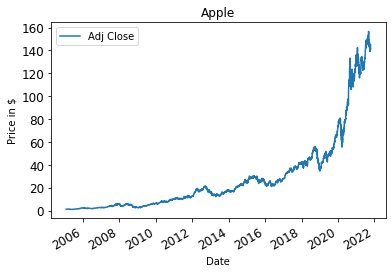

In [17]:
# Define a date range
start_date = datetime(2005, 1, 29)
end_date = datetime.today()

# Define ticker symbols
ticker_symbols = ['GOOG', "AAPL"]

# Create a dataframe with the apple stock price
apple_df = get_stock_data(ticker_symbols, start_date, end_date, columns=["Adj Close"])["AAPL"]

# Plot the data
plot_data(title="Apple" , df=apple_df)

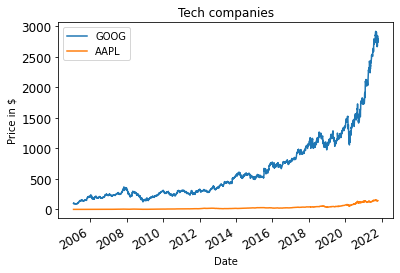

In [18]:
# Get data for multiple ticker symbols
data = get_stock_data(ticker_symbols, start_date)
formated_data = tickers_as_columns(data)

plot_data(title="Tech companies", df = formated_data)

## Train and store models

In [19]:
pred_base_range = 60
# ABNB_model = create_model("ABNB", "AirBNB Model", start_date, end_date = datetime.today(), pred_base_range = pred_base_range)
# BTC_USD_model = create_model("BTC-USD", "BTC-USD Model", start_date, end_date = datetime.today(), pred_base_range = pred_base_range)
# GOOG_model = create_model("GOOG", "Google Model", start_date, end_date = datetime.today(), pred_base_range = pred_base_range)
# AAPL_model = create_model("AAPL", "Apple Model", start_date, end_date = datetime.today(), pred_base_range = pred_base_range)
# save_model_dict(ABNB_model)
# save_model_dict(BTC_USD_model)
# save_model_dict(GOOG_model)
# save_model_dict(AAPL_model)

## Load models

In [20]:
loaded_model = load_model_dict("BTC-USD Model")
loaded_model

2021-10-16 12:47:00.664884: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-10-16 12:47:00.664918: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-10-16 12:47:00.664941: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (martin-ThinkPad-T490): /proc/driver/nvidia/version does not exist
2021-10-16 12:47:00.665190: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


{'name': 'BTC-USD Model',
 'ticker': 'BTC-USD',
 'start_date': datetime.datetime(2005, 1, 29, 0, 0),
 'end_date': datetime.datetime(2021, 10, 16, 11, 48, 18, 533354),
 'pred_base_range': 60,
 'model': <keras.engine.sequential.Sequential at 0x7f20ad7b5670>}

## Predict future data based on model

In [100]:
df_btc_usd = get_adj_close_df(["BTC-USD"], start_date, end_date = datetime.today())
df_btc_usd_values = df_btc_usd.values
predict_future(df_values, loaded_model, n_days = 20)

array([56564.7469251 , 56325.23838143, 55657.63416531, 54823.83025432,
       53958.16121777, 53128.88437454, 52369.59271011, 51694.61737128,
       51107.14686382, 50603.87620403, 50177.79242329, 49819.94665224,
       49520.61142566, 49270.04370641, 49058.99813582, 48879.05342109,
       48722.81601594, 48584.00483186, 48457.48861071, 48339.22737429])

## Test Bitcoin prediction for 500 days

In [101]:
BTC_USD_model_500 = create_model("BTC-USD", "BTC-USD Model 500d", start_date, end_date = datetime.today(), pred_base_range = 500)
save_model_dict(BTC_USD_model_500)

1309/1309 [==============================] - 231s 175ms/step - loss: 2.9157e-04


In [102]:
predictions = predict_future(df_btc_usd_values, BTC_USD_model_500, n_days = 5)
timerange = create_timerange_from_now(include_today = False, weekends = True)
extend_df(df, predictions, timerange)

,BTC-USD
2014-09-16,457.334015
2014-09-17,424.440002
2014-09-18,394.795990
2014-09-19,408.903992
2014-09-20,398.821014
...,...
2021-10-17,56390.694001
2021-10-18,56312.437020
2021-10-19,55936.339093
2021-10-20,55435.830269


## Preprocess the data and divide it into train and test set

### Create model

In [25]:
# first_lstm = get_model(input_shape = x_train.shape[1])
# first_lstm.fit(x_train, y_train, batch_size=1, epochs=1)
# store_model_keras("first_lstm", first_lstm)

### Load model from disk

In [26]:
# google_model = load_model("Google Model")

In [27]:
# model_dict = {}
# model_dict["name"] = "Google Model"
# model_dict["model"] = google_model
# model_dict["start_date"] = start_date
# model_dict["end_date"] = end_date
# model_dict["ticker_symbols"] = ["GOOG"]
# model_dict["pred_base_range"] =  pred_base_range

In [28]:
# test_dates = []
# test_dates.append(datetime(year = 2021, month = 9, day = 15))
# test_dates.append(datetime(year = 2021, month = 9, day = 17))
# test_dates.append(datetime(year = 2020, month = 9, day = 17))
# test_dates.append(datetime(year = 2021, month = 10, day = 17))

In [29]:
# # Making predictions on the testing data
# prediction = make_predictions(first_lstm, x_test)
# predictions = rescale_data(prediction, scaler)

In [30]:
# prediction.shape

In [31]:
# plot_approximation(filtered_data=filtered_data, training_data_len= training_data_len, predictions=predictions)

In [32]:
# goog_price = predict_future(dataset, google_model)

In [33]:
# dt1 = datetime(year = 2021, month = 9, day=20)
# dt2 = datetime(year = 2021, month = 9, day=24)
# dt_range  = pd.date_range(start = dt1, end = dt2)

In [34]:
# google_prediction_df = pd.DataFrame(goog_price, index = dt_range, columns = ["Predicted GOOG price"])

In [35]:
# google_prediction_df